# Audio Recording

In [1]:
import pyaudio
import wave

FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100
CHUNK = 1024
RECORD_SECONDS = 10
WAVE_OUTPUT_FILENAME = "test.wav"
 
audio = pyaudio.PyAudio()
 
# start Recording
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,
                frames_per_buffer=CHUNK)
print("recording...")
frames = []
 
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
print("finished recording")
 
# stop Recording
stream.stop_stream()
stream.close()
audio.terminate()
 
waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(frames))
waveFile.close()

recording...
finished recording


## Audio Recording Test

In [2]:
import IPython.display as ipd
ipd.Audio('test.wav')

Populating the interactive namespace from numpy and matplotlib


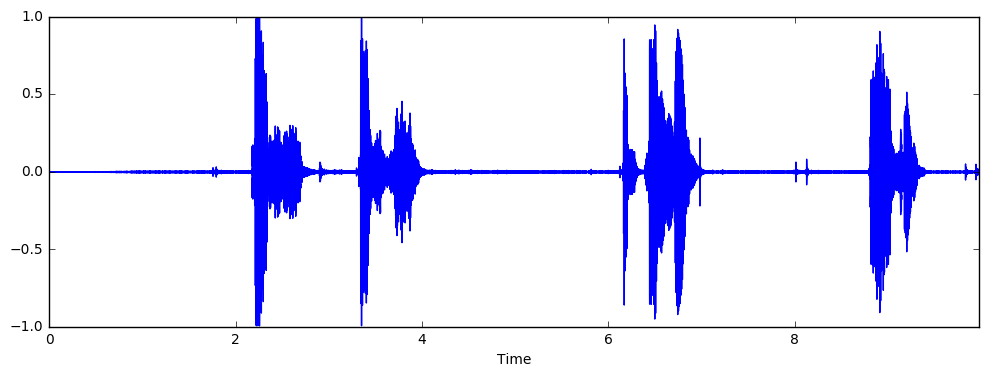

In [3]:
% pylab inline
import os
import pandas as pd
import librosa
import librosa.display
import glob

data, sampling_rate = librosa.load('test.wav')
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

# RGB-D Recording

In [13]:
import sys
import time
import cv2
import numpy as np
import pyrealsense as pyrs
from pyrealsense.constants import rs_option, rs_format, rs_stream
from matplotlib import pyplot as plt

# Fire camera & launch streams
serv = pyrs.Service()
serv.start()
cam = serv.Device(device_id = 0, streams = [pyrs.stream.ColorStream(fps=30),
                                           pyrs.stream.DepthStream(fps=30),
                                           pyrs.stream.InfraredStream(fps=30)], 
                  depth_control_preset = 5, ivcam_preset = 8)

try:  # set custom auto exposure and emitter to obtain good depth image
    custom_options = [(rs_option.RS_OPTION_R200_LR_AUTO_EXPOSURE_ENABLED, 1),
                      (rs_option.RS_OPTION_R200_EMITTER_ENABLED, 1),
                      (rs_option.RS_OPTION_R200_LR_GAIN, 2)]
    cam.set_device_options(*zip(*custom_options))
except pyrs.RealsenseError:
    pass  # options are not available on all devices

file_num = 0

# Start fetching Buffer
print('Starting Buffer...')
for i in range(30):
    cam.wait_for_frames()
    current_color = cam.color[:,:,::-1]
    current_depth = np.uint16(cam.depth)

    cv2.imshow('Color', current_color)
    cv2.imshow('Depth', current_depth * 255 / 1000)
    cv2.imshow('Infrared', cam.infrared)

    num = format(file_num, '08')
    cv2.imwrite('testDepth' + str(num) + '.png', current_depth * 255 / 1000)
    cv2.imwrite('testRGB' + str(num) + '.png', current_color)
    cv2.imwrite('testInfrared' + str(num) + '.png', cam.infrared)
    file_num += 1

print('Buffer stopped.')
cv2.destroyAllWindows()
cam.stop()
serv.stop()

Starting Buffer...
Buffer stopped.


# RGB-D Recording Test

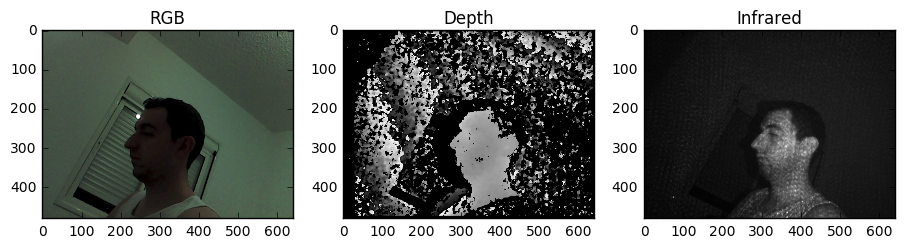

In [14]:
import matplotlib.image as mpimg
%matplotlib inline

fig = plt.figure(figsize=(11,8))

i = 1
fig.add_subplot(1, 3, i)
num = format(i, '08')
imgRGB=mpimg.imread('testRGB'+str(num)+'.png')
imgDepth=mpimg.imread('testDepth'+str(num)+'.png')
imgInfrared=mpimg.imread('testInfrared'+str(num)+'.png')
plt.imshow(imgRGB)
plt.title("RGB")
i += 1
fig.add_subplot(1, 3, i)
plt.imshow(imgDepth, cmap='gray')
plt.title("Depth")
i += 1
fig.add_subplot(1, 3, i)
plt.imshow(imgInfrared, cmap='gray')
plt.title("Infrared")
plt.show()

# Final Record script

In [15]:
import os
import sys
import cv2
import re
import numpy as np
import pyrealsense as pyrs
from pyrealsense.constants import rs_option, rs_format, rs_stream
from matplotlib import pyplot as plt

def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        return 1
    else:
        print(directory, '- already exists')
        return 0


def check_directories(place):
    try:
        create_directory('./data')
        create_directory('./data/depth')
        create_directory('./data/color')
        create_directory('./data/infrared')
        create_directory('./data/depth/' + place)
        create_directory('./data/color/' + place)
        create_directory('./data/infrared/' + place)
    except:
        print("Unexpected error:", sys.exc_info()[0])
        return -1
    return 0

def extract_number(f):
    s = re.findall("\d+",f)
    return (int(s[0]) if s else 0)

def main(place, record_time):
    file_structure = check_directories(place)
    if file_structure == -1:
        print('\nERROR: Directories can\'t be created, error thrown')
        return -1
    else:
        print('\nDirectories created successfully...\nLaunching camera module...')

    # Fire camera & launch streams
    serv = pyrs.Service()
    serv.start()
    cam = serv.Device(device_id = 0, streams = [pyrs.stream.ColorStream(fps=30),
                                               pyrs.stream.DepthStream(fps=30),
                                               pyrs.stream.InfraredStream(fps=30)], 
                      depth_control_preset = 5, ivcam_preset = 8)
   
    try:  # set custom auto exposure and emitter to obtain good depth image
        custom_options = [(rs_option.RS_OPTION_R200_LR_AUTO_EXPOSURE_ENABLED, 1),
                          (rs_option.RS_OPTION_R200_EMITTER_ENABLED, 1),
                          (rs_option.RS_OPTION_R200_LR_GAIN, 2)]
        cam.set_device_options(*zip(*custom_options))
    except pyrs.RealsenseError:
        pass  # options are not available on all devices
    
    # Some important variables
    flag_save_frames = True
    file_list = [name for name in os.listdir('./data/color/' + place)]
    file_num = int(max(file_list,key=extract_number)[:8]) + 1
    
    # Start fetching Buffer
    print('Starting Buffer...')
    for i in range(30 * record_time):
        cam.wait_for_frames()
        current_color = cam.color[:,:,::-1]
        current_depth = np.uint16(cam.depth)
        cv2.imshow('Color', current_color)
        cv2.imshow('Depth', current_depth * 255 / 1000)
        cv2.imshow('Infrared', cam.infrared)

        if flag_save_frames:
            num = format(file_num, '08')
            cv2.imwrite('./data/depth/' + place + '/' + str(num) + '.png', current_depth * 255 / 1000)
            cv2.imwrite('./data/color/' + place + '/' + str(num) + '.png', current_color)
            cv2.imwrite('./data/infrared/' + place + '/' + str(num) + '.png', cam.infrared)
            file_num += 1

        k = cv2.waitKey(1)
        if k == ord('q'):
            print('Q Pressed...\nEnding execution')
            break
        if k == ord('f'):
            if flag_save_frames:
                print('F Pressed...\nStopped fetching frames...')
                flag_save_frames = False
            else:
                print('F Pressed...\nStarted fetching frames...')
                flag_save_frames = True
    
    cv2.destroyAllWindows()
    cam.stop()
    serv.stop()

if __name__ == '__main__':
    print(__doc__)
    main('classroom', 3)

Automatically created module for IPython interactive environment
./data - already exists
./data/depth - already exists
./data/color - already exists
./data/infrared - already exists
./data/depth/classroom - already exists
./data/color/classroom - already exists
./data/infrared/classroom - already exists

Directories created successfully...
Launching camera module...
Starting Buffer...
